<a href="https://colab.research.google.com/github/2714830587-xh/CLRS-GG/blob/master/CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from keras.datasets import mnist
from keras.layers import Conv2D, Dense, GlobalAveragePooling2D
from keras.models import Model, Input
from tensorflow.keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train_resized = x_train.reshape((60000, 28, 28, 1))
x_test_resized = x_test.reshape((10000, 28, 28, 1))
y_train_hot_encoded = to_categorical(y_train)
y_test_hot_encoded = to_categorical(y_test)

inputs = Input(shape=(28,28, 1))

x = Conv2D(64, (3,3), activation='relu')(inputs)
x = Conv2D(64, (3,3), activation='relu', name='final_conv')(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train_resized, y_train_hot_encoded, epochs=10, batch_size=256, shuffle=True, validation_split=0.3)

Epoch 1/10
165/165 [==============================] - 160s 964ms/step - loss: 2.2324 - accuracy: 0.3407 - val_loss: 2.0671 - val_accuracy: 0.3651
Epoch 2/10
165/165 [==============================] - 161s 976ms/step - loss: 1.0917 - accuracy: 0.6431 - val_loss: 1.2113 - val_accuracy: 0.6149
Epoch 3/10
165/165 [==============================] - 160s 969ms/step - loss: 0.7904 - accuracy: 0.7492 - val_loss: 0.8025 - val_accuracy: 0.7106
Epoch 4/10
165/165 [==============================] - 161s 974ms/step - loss: 0.6305 - accuracy: 0.8009 - val_loss: 0.6496 - val_accuracy: 0.7914
Epoch 5/10
165/165 [==============================] - 160s 968ms/step - loss: 0.5153 - accuracy: 0.8409 - val_loss: 0.8278 - val_accuracy: 0.7273
Epoch 6/10
165/165 [==============================] - 160s 969ms/step - loss: 0.4367 - accuracy: 0.8647 - val_loss: 0.8337 - val_accuracy: 0.7189
Epoch 7/10
165/165 [==============================] - 160s 970ms/step - loss: 0.3833 - accuracy: 0.8826 - val_loss: 0.5373 -

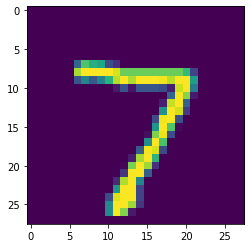

0.998 -> 7
0.001 -> 2
0.000 -> 9
0.000 -> 3
0.000 -> 5
(28, 28)


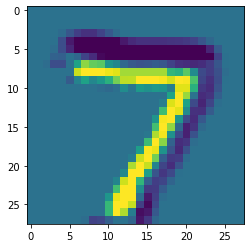

In [4]:
import numpy as np
import cv2
import io
import requests
from PIL import Image
import matplotlib.pyplot as plt
# Using Keras implementation from tensorflow
from tensorflow.python.keras import applications
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array 
from tensorflow.python.keras import backend as K


# Get the layer of the last conv layer
fianlconv = model.get_layer('final_conv')
# Get the weights matrix of the last layer
weight_softmax = model.layers[-1].get_weights()[0]

# Function to generate Class Activation Mapping
HEIGHT = 28
WIDTH = 28

def returnCAM(feature_conv, weight_softmax, class_idx):
    size_upsample = (WIDTH, HEIGHT)

    # Keras default is channels last, hence nc is in last
    bz, h, w, nc = feature_conv.shape

    output_cam = []
    for idx in class_idx:
        cam = np.dot(weight_softmax[:, idx], np.transpose(feature_conv.reshape(h*w, nc)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)

        output_cam.append(cv2.resize(cam_img, size_upsample))

    return output_cam

x = x_test_resized[0,:,:,0]

plt.imshow(x)
plt.show()

classes = {1:'1', 2: '2', 3: '3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9', 0:'0'}

probs_extractor = K.function([model.input], [model.output])
features_conv_extractor = K.function([model.input], [fianlconv.output])

probs = probs_extractor([np.expand_dims(x, 0).reshape(1,28,28,1)])[0]

features_blob = features_conv_extractor([np.expand_dims(x, 0).reshape(1,28,28,1)])[0]

features_blobs = []
features_blobs.append(features_blob)

idx = np.argsort(probs)
probs = np.sort(probs)

for i in range(-1, -6, -1):
    print('{:.3f} -> {}'.format(probs[0, i], classes[idx[0, i]]))


CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0, -1]])

heatmap = cv2.applyColorMap(cv2.resize(CAMs[0], (28, 28)), cv2.COLORMAP_JET)

result = heatmap[:,:,0] * 0.3 + x * 0.5

print(result.shape)

plt.imshow(result)
plt.show()